Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 11.3MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 890kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=cfb8d050714fad3ab41e0ada0f22a833385437de0ca696d5283c1994f87ac9c4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 12.5MB/s 


In [5]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [63]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report

Model_name = "HooshvareLab/bert-fa-base-uncased"

In [7]:
# specify GPU
device = torch.device("cuda")

## Data

In [110]:
limit_number = 750
data = pandas.read_csv('../Data/ParsBert.csv')
data = data.dropna().reset_index(drop=True)
X = data["body"].values.tolist()
y = pandas.read_csv('../Data/ParsBert.csv')
labels = []
tag=[]
for item in y['tag']:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

In [113]:
len(labels) , len(X)

(78, 5422)

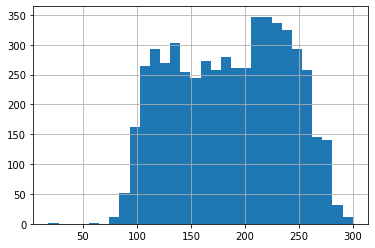

In [114]:
seq_len = [len(i.split()) for i in X]
pandas.Series(seq_len).hist(bins = 30)

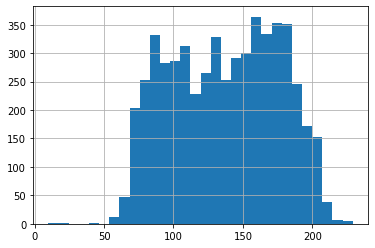

In [115]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  3252 
test:  1085 
val:  1085 
y_tain: 3252


In [117]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [118]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['سلام', 'به', 'اهالی', 'خوب', 'خاورمیانه', 'میدونم', 'درگیری', 'دارین', 'شمام', 'با', 'این', 'ide', 'و', 'ide', 'های', 'مشابه', 'مثل', 'php', '##storm', 'و', 'نه', 'صرفه', 'داره', 'بخرید', 'نه', 'اصن', 'بهتون', 'میفروش', '##ن', 'اما', 'خیلی', 'اعصاب', 'خورد', '##کنه', 'چن', '##وقت', 'یب', '##ار', 'دنباله', 'روش', 'کرک', 'مناسب', 'گشتن', 'اگه', 'به', 'کسی', 'نمیگ', '##ید', 'میخوام', 'بگم', 'چجوری', 'تو', 'لینوکس', 'اون', 'مدت', '۳۰', 'روزه', 'رو', 'ریست', 'کنید', '.', 'کافیه', 'سه', 'تا', 'فایل', 'رو', 'پاک', 'کنید', 'ولی', 'قبلش', 'باید', 'جایی', 'که', 'intel', '##ij', 'فایل', '##ای', 'کانفی', '##گش', 'رو', 'ذخیره', 'میکنه', 'رو', 'پیدا', 'کنید', 'معمولا', 'توی', 'home', 'میذ', '##ارت', '##ش', 'ولی', 'ممکنه', 'تغییرش', 'بده', 'ورژن', 'به', 'ورژن', 'و', 'راه', 'ساد', '##ش', 'اینه', 'برید', 'توی', 'home', 'و', 'عبارت', '[UNK]', 'رو', 'سرچ', 'کنید', '(', 'به', 'تناسب', 'ورژن', '##تون', ')', 'من', 'اینکارو', 'با', 'همون', 'file', 'explor', '##e', 'گنوم', 'انجام', 'میدم', 'با', 'رفتن', 'تو

In [119]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [120]:
sent_id

{'input_ids': [[2, 4285, 2789, 6694, 4124, 6942, 30481, 6058, 43343, 94027, 2799, 2802, 27864, 1379, 27864, 6343, 4942, 3826, 46558, 90093, 1379, 3254, 7679, 11231, 13879, 3254, 82516, 32701, 34976, 2011, 2949, 3805, 10267, 4598, 10533, 12459, 9804, 14014, 2785, 9346, 3541, 11457, 4006, 29088, 12516, 2789, 4035, 30265, 2805, 17953, 18757, 65889, 2861, 12617, 5536, 3679, 3979, 7010, 2840, 31040, 3116, 1012, 54770, 3140, 2848, 6921, 2840, 4679, 3116, 3362, 40273, 3013, 4571, 2800, 25358, 28121, 6921, 2784, 62986, 7506, 2840, 5605, 12702, 2840, 3510, 3116, 3937, 6651, 26096, 43488, 3094, 2014, 3362, 20867, 69503, 3791, 21001, 2789, 21001, 1379, 3148, 20401, 2014, 9225, 21961, 6651, 26096, 1379, 4226, 1, 2840, 27069, 3116, 1006, 2789, 11007, 21001, 4957, 1007, 2842, 85197, 2799, 17802, 28817, 44257, 2033, 44031, 3096, 27409, 2799, 5200, 2861, 26096, 1379, 5673, 50980, 1009, 1031, 2800, 3680, 5101, 2802, 10672, 1014, 20867, 12459, 3891, 3680, 53735, 2800, 2964, 9346, 34154, 4590, 2800, 3685

In [121]:
sentence_maxlen=128

In [122]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [123]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [124]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.tensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.tensor(y_test)

In [125]:
train_y[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [126]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [127]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained(Model_name)
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)

{'input_ids': [[2, 32071, 9574, 1026, 89390, 36260, 84378, 40908, 2041, 4, 0], [2, 13632, 25909, 70608, 1011, 40716, 2033, 1026, 89390, 36260, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.9919,  0.0981,  1.0746,  ...,  0.4275,  0.1416, -0.8444],
         [ 0.1278,  1.2993, -1.5561,  ..., -0.4052, -0.0262, -0.9568],
         [-0.4283, -0.5914, -0.0802,  ..., -0.1228, -0.5051,  0.2659],
         ...,
         [-0.7192, -0.7666, -0.7105,  ...,  1.2001,  0.6686, -0.7979],
         [-0.2818, -0.5135,  0.7244,  ...,  0.2886,  0.0698, -0.5266],
         [-1.3168,  0.0980, -0.4526,  ...,  0.3502, -0.2239, -0.7427]],

        [[-0.4695, -0.4073,  0.8762,  ...,  0.7422, -0.2326, -0.7650],
         [ 0.2054, -0.4946, -0.5946,  ...,  0.6374, -0.3904, -0.4286],
         [ 0.0755, -0.6795, -0.2105,  ..., -0.2501,  0.0618, -0.7201],
         ...,
         [-0.2454, -0.1457, -0

## Model

In [128]:
transformer_model = AutoModel.from_pretrained(Model_name)

In [129]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False

In [130]:
len(labels)

78

In [131]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,78)

      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs[1])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply sigmoid activation
      x = self.sigmoid(x)

      return x

In [132]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [154]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [155]:
loss_func =nn.MultiLabelSoftMarginLoss()

In [156]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    
    loss = loss_func(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [157]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = loss_func(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [163]:
# number of training epochs
epochs = 100

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 2 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 3 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 4 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 5 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 6 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 7 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966
Validation Loss: 0.966

 Epoch 8 / 100
  Batch    50  of    102.
  Batch   100  of    102.

Evaluating...

Training Loss: 0.966

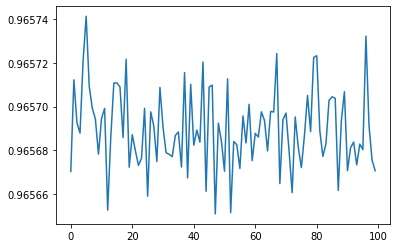

In [165]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

Loading saved model:

In [160]:
# # torch.cuda.empty_cache()
# # pass the pre-trained BERT to our define architecture
# model = BERT_Arch(transformer_model)

# # push the model to GPU
# model = model.to(device)

In [161]:
# #load weights of best model
# path = 'ParsBERT_pytorch_balanced.pt'
# model.load_state_dict(torch.load(path))

FileNotFoundError: ignored

After loading model:

In [164]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      preds = preds.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in preds:
      temp=[]
      for value in l:
        if value >= measure:
          temp.append(1)
        else:
          temp.append(0)
      y_pred.append(temp)
    y_true.extend(labels.cpu().numpy())
    # print(labels.cpu().numpy()[0], preds[0])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.38      0.03        13
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        23
          11       0.01      0.78      0.02         9
          12       0.01      0.08      0.02        12
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00        12
          15       0.01      1.00      0.03        10
          16       0.00      0.00      0.00         9
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
